In [141]:
import astropy.units as u
import numpy as np
from astroquery.gaia import Gaia
from joblib import Memory

In [158]:
def get_gaia_query_results(ra=66.75, dec=15.86, radius=2, conds="", limit=50000):
    add = ""
    if conds != "":
        add = f"AND {conds}"
    query = f"""
    SELECT TOP {limit} *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',{ra},{dec},{radius})
        )=1
    """ + add
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [159]:
location = "./cachedir"
memory = Memory(location, verbose=0)
get_gaia_query_results_cached = memory.cache(get_gaia_query_results)

In [160]:
stringent_conds = '''
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>50
    AND phot_rp_mean_flux_over_error>20
    AND phot_bp_mean_flux_over_error>20
    AND pmra_error < 0.1
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
'''
res_stringent = get_gaia_query_results_cached(conds = stringent_conds)
res_condless = get_gaia_query_results_cached()

INFO:astropy:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astropy:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
    solution_id              designation          ...       ecl_lat      
                                                  ...         deg        
------------------- ----------------------------- ... -------------------
1636042515805110273 Gaia EDR3 3310910234592413184 ...   -7.09642140318053
1636042515805110273 Gaia EDR3 3310910303311887360 ...  -7.099390155134367
1636042515805110273 Gaia EDR3 3310910676972829696 ...  -7.067237618345579
1636042515805110273 Gaia EDR3 3310910681269000448 ...  -7.066406491291075
1636042515805110273 Gaia EDR3 3310910951850745984 ...  -7.041628454089132
1636042515805110273 Gaia EDR3 3310911093585979776 ...  -7.187608245666195
1636042515805110273 Gaia EDR3 3310911127945715968 ...  -7.188595573408486
1636042515805110273 Gaia EDR3 3310911127945717248 ...  -7.187677529267409
1636042515805110273 Gaia EDR3 3310911265384672384 ... -7.1733817785511516
1636042515805110273 Gaia EDR3 3310911368463886464 ...  -7.1646

In [206]:
import matplotlib.pyplot as plt
from matplotlib import colors

### Stringent Conditions

In [169]:
res_stringent

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 3310910234592413184,3310910234592413184,521429206,2016.0,66.88549970215922,0.048095696,14.554533716674962,0.0241279,2.709909134462023,0.051859166,52.25516,11.642781,3.8920418063515654,0.071100816,-10.972983353271964,0.045994453,0.44110656,0.123208195,0.28040534,0.056733746,0.11185328,-0.0045747715,0.4617484,0.23918591,0.015497527,-0.10481648,555,0,554,1,1.2579513,616.02734,0.0,0.0,31,False,1.3226537,--,--,--,--,--,--,--,63,16,0.10019335,63,6,0,0.040260464,161.72054,0,0,1.0375876,0.47359958,0.7079789,0.4843971,0.33157468,174.30005,-13.890505,49.807804,-20.225327,False,546,5870.630264696533,2.3785326,2468.173,16.265656,55,1521.3159725124406,5.9115076,257.34824,17.382994,54,6429.755194622723,7.812238,823.03625,15.227409,0,4,0,2,0,1.3543812,2.1555843,1.1173382,1.0382462,--,--,0,--,--,--,181.2780864081062,-23.043409515950643,67.48626892482422,-7.09642140318053
1636042515805110273,Gaia EDR3 3310910303311887360,3310910303311887360,1182667148,2016.0,66.92686962636793,0.05875874,14.557902591327244,0.029379366,1.7049064454535225,0.06243842,27.305407,11.86624,-0.4717218209513101,0.08741857,-

In [211]:
bp_rp = res_stringent['bp_rp'].data
phot_g_mean_mag = res_stringent['phot_g_mean_mag'].data
parallax = res_stringent['parallax'].data
ra = res_stringent['ra'].data
dec = res_stringent['dec'].data
mg = phot_g_mean_mag+5*np.log10(parallax)-10

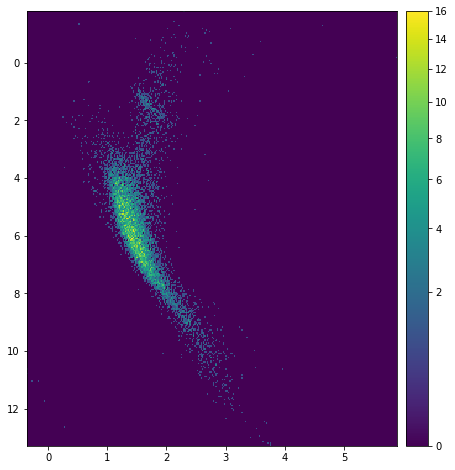

In [163]:
fig, ax = plt.subplots(figsize=(8,8))
h = ax.hist2d(bp_rp,mg,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()

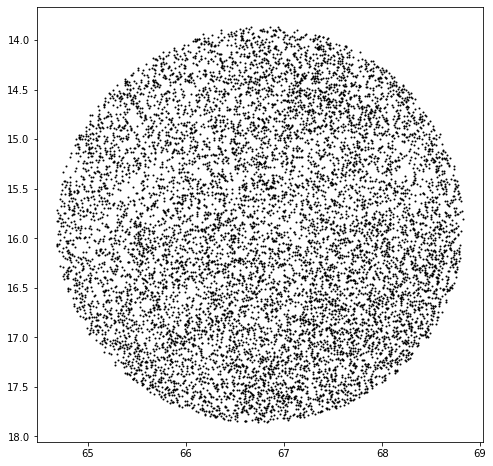

In [215]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(ra, dec, s=1, color='k', zorder=0)
ax.invert_yaxis()
plt.show()

### Conditionless (Limit 50,000)


In [170]:
res_condless

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 3310910234591649920,3310910234591649920,1681027601,2016.0,66.8959686611176,1.0560373,14.545497139263611,0.51895314,-0.6134788882131914,1.1343426,-0.54082334,4.599394,3.5033289453266923,1.7233998,-2.9801193101200525,1.1023573,0.44158155,0.2942498,0.2720782,-0.07346721,0.30381653,-0.09544827,0.37709513,0.21438496,0.15029892,-0.088421196,329,0,327,2,1.2224809,383.261,1.270954,0.61286545,95,False,--,1.2727184,0.16911666,-0.05016294,-0.21246184,0.021009091,0.12401283,0.17940193,38,14,2.4168394,40,5,1,0.04003031,153.6852,0,0,1.0475786,0.2886455,0.7214362,0.44218978,0.34657437,168.17084,-14.003793,48.72844,-20.9142,False,321,99.0610233340067,0.6820931,145.23094,20.697609,26,54.11922778383128,7.0207286,7.708492,21.005163,31,93.76212855813576,7.6686244,12.226721,19.817827,0,0,0,0,0,1.4928309,1.187336,0.30755424,0.8797817,--,--,0,--,--,--,181.29262607146194,-23.041101508120093,67.4949205944182,-7.1069396860215965
1636042515805110273,Gaia EDR3 3310910234592413184,3310910234592413184,521429206,2016.0,66.88549970215922,0.048095696,14.554533716674962,0.0241279,2.709909134462023,0.051859166,52.2

In [201]:
res_condless_pd = res_condless.to_pandas()
res_condless_pd = res_condless_pd[res_condless_pd['parallax'].notna()]
res_condless_pd = res_condless_pd[res_condless_pd['parallax'] > 0.5]
res_condless_pd = res_condless_pd[res_condless_pd['bp_rp'].notna()]

In [208]:
bp_rp = res_condless_pd['bp_rp']
phot_g_mean_mag = res_condless_pd['phot_g_mean_mag']
parallax = res_condless_pd['parallax']
ra = res_condless_pd['ra']
dec = res_condless_pd['dec']
mg = phot_g_mean_mag+5*np.log10(parallax)-10

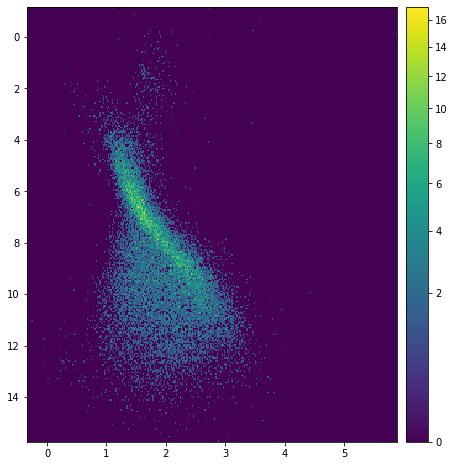

In [204]:
fig, ax = plt.subplots(figsize=(8,8))
h = ax.hist2d(bp_rp,mg,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()

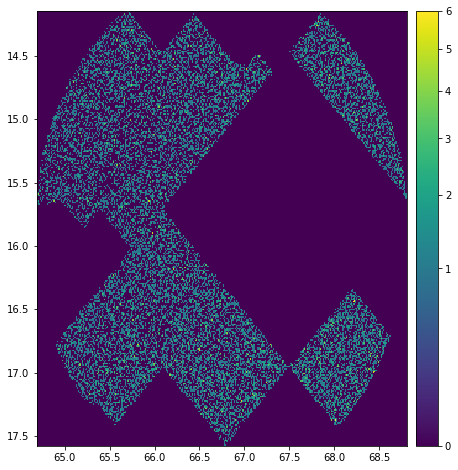

In [209]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(ra, dec, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()